In [1]:
from Padd.models import PowerPaintControlNet
from Padd import ObjectAdder
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
from PIL import Image
import torch
import numpy as np
from diffusers.utils import load_image
import diffusers

%load_ext autoreload
%autoreload 2

/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


### Necessory functions

In [2]:
def GetMaskedImage(image, mask):
    mask_np = np.array(mask.convert("RGB"))

    red = np.array(image).astype("float") * 1
    red[:, :, 0] = 180.0
    red[:, :, 2] = 0
    red[:, :, 1] = 0
    result_m = np.array(image)
    result_m = Image.fromarray(
        (result_m.astype("float") * (1 - mask_np.astype("float") / 512.0)
        + mask_np.astype("float") / 512.0 * red
        ).astype("uint8"))
    return result_m

def CombineImagesHorizontally(*images):
    if not images:
        raise ValueError("No images provided")

    total_width = sum(img.width for img in images)
    max_height = max(img.height for img in images)

    combined_image = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for img in images:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width

    return combined_image

### Look at the data

In [4]:
image = Image.open("examples/image.jpg")
cat_mask = Image.open("examples/cat_mask.jpg")
person_mask = Image.open("examples/person_mask.png")

image_landscape = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")

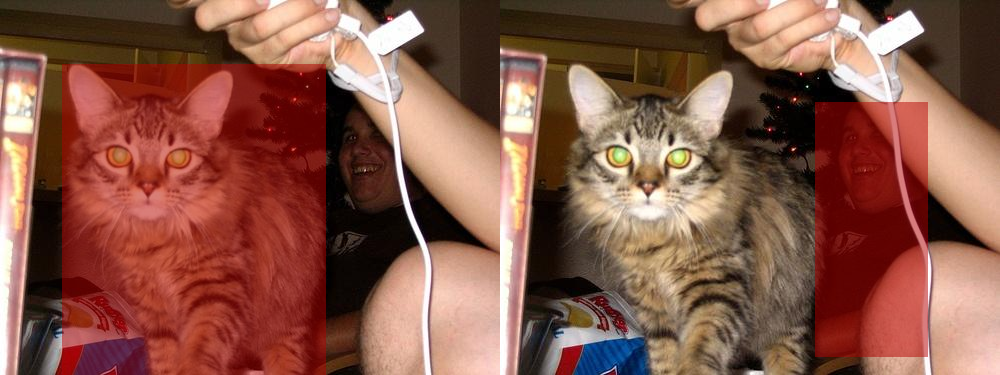

In [5]:
CombineImagesHorizontally(GetMaskedImage(image, cat_mask), GetMaskedImage(image, person_mask)).show()

### Depth extraction

In [3]:
def get_depth_map(image, ImageProcessor, ModelForDepthEstimation):
        image = ImageProcessor(images=image, return_tensors="pt").pixel_values.to("cuda")
        with torch.no_grad(), torch.autocast("cuda"):
            depth_map = ModelForDepthEstimation(image).predicted_depth

        depth_map = torch.nn.functional.interpolate(
            depth_map.unsqueeze(1),
            size=(1024, 1024),
            mode="bicubic",
            align_corners=False,
        )
        depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
        depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
        depth_map = (depth_map - depth_min) / (depth_max - depth_min)
        image = torch.cat([depth_map] * 3, dim=1)

        image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
        image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
        return image

#### Depth-Anything

In [4]:
ImageProcessor = AutoImageProcessor.from_pretrained("LiheYoung/depth-anything-small-hf")
DepthAnything = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf").to("cuda")

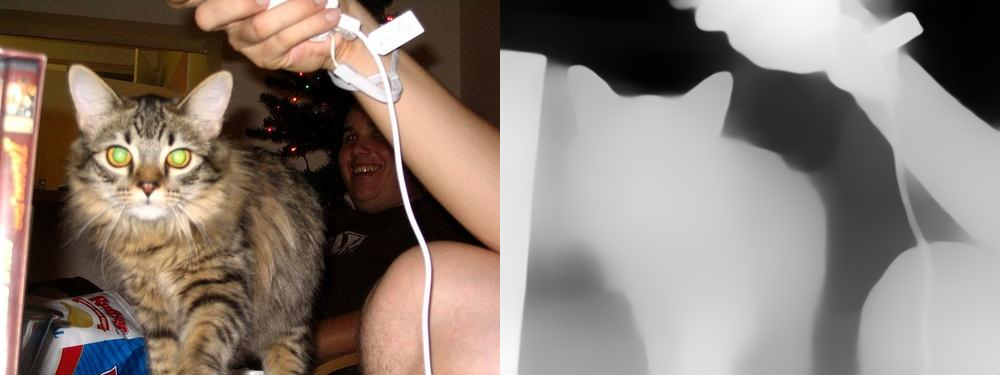

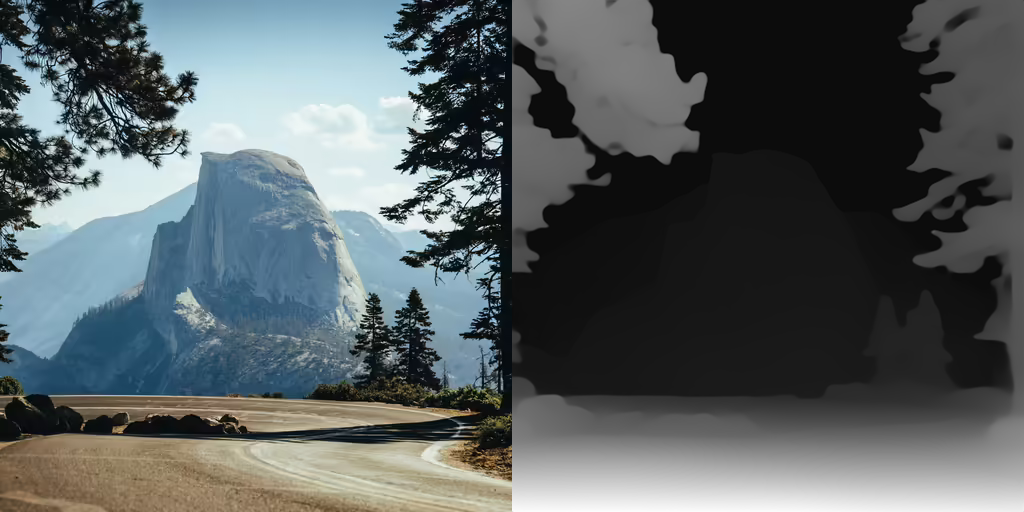

In [12]:
CombineImagesHorizontally(image, 
                          get_depth_map(image, ImageProcessor, DepthAnything).resize(image.size)).show()

CombineImagesHorizontally(image_landscape, 
                          get_depth_map(image_landscape, ImageProcessor, DepthAnything).resize(image_landscape.size)).show()

#### Depth-Anything v2

In [5]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

ImageProcessor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
DepthAnythingv2 = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to("cuda")

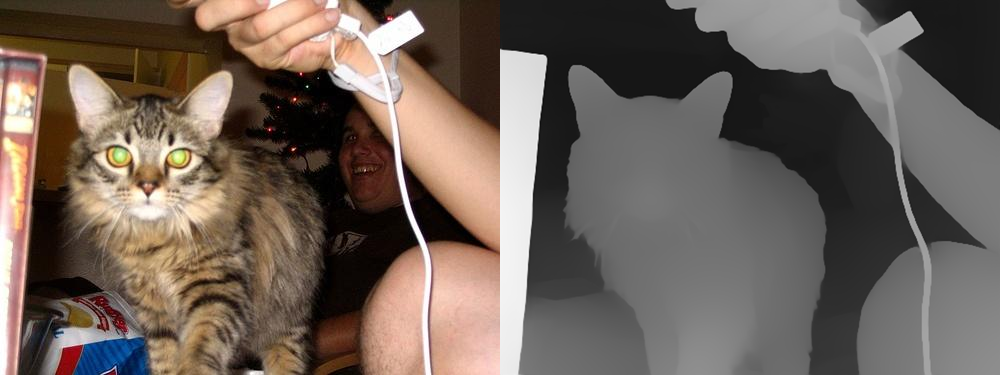

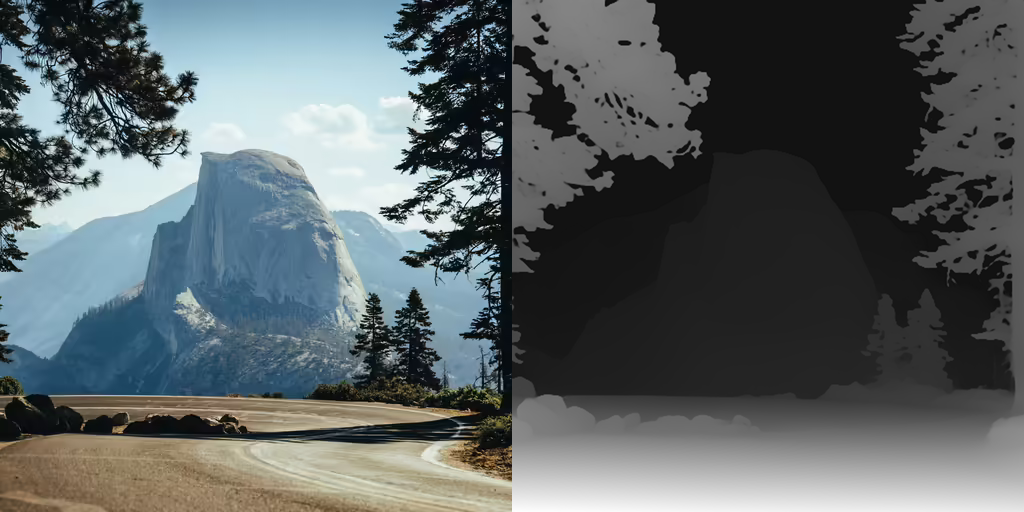

In [14]:
CombineImagesHorizontally(image, 
                          get_depth_map(image, ImageProcessor, DepthAnythingv2).resize(image.size)).show()

CombineImagesHorizontally(image_landscape, 
                          get_depth_map(image_landscape, ImageProcessor, DepthAnythingv2).resize(image_landscape.size)).show()

#### Marigold

In [ ]:
pipe = diffusers.MarigoldDepthPipeline.from_pretrained(
    "prs-eth/marigold-depth-lcm-v1-0", prediction_type="depth", variant="fp16", torch_dtype=torch.float16).to("cuda")

Marigold predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Diffusion steps...:   0%|          | 0/1 [00:00<?, ?it/s]

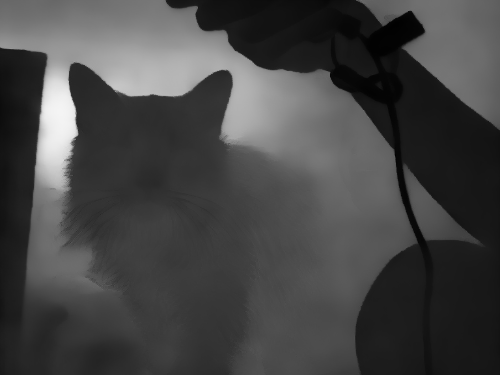

In [74]:
image = Image.open("examples/image.jpg")
depth_map = pipe(image)
depth_16bit = pipe.image_processor.export_depth_to_16bit_png(depth_map.prediction)
depth_16bit[0]

Marigold predictions...:   0%|          | 0/1 [00:00<?, ?it/s]

Diffusion steps...:   0%|          | 0/1 [00:00<?, ?it/s]

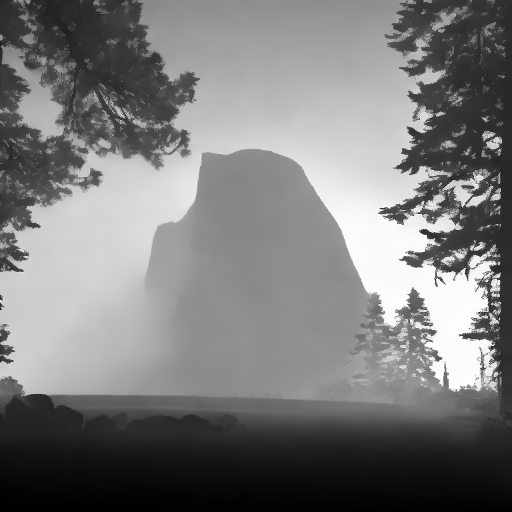

In [75]:
image_landscape = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
depth_map = pipe(image_landscape)
depth_16bit = pipe.image_processor.export_depth_to_16bit_png(depth_map.prediction)
depth_16bit[0]

### PowerPaint with ControlNet

In [6]:
model = PowerPaintControlNet()

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/unet: Error no file named diffusion_pytorch_model.safetens

09/12 17:53:40 - mmengine - INFO - Successfully add external embeddings: P_ctxt, P_shape, P_obj.
09/12 17:53:40 - mmengine - INFO - Successfully add trainable external embeddings: P_ctxt, P_shape, P_obj


/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/controlnet_aux/open_pose/body.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer

In [7]:
img = {"image": image, "mask": cat_mask}

NameError: name 'image' is not defined

In [ ]:
new_image, controlnet_image = model(
        input_image=img,
        control_type="depth",
        prompt="white dog",
        ddim_steps=50,
        scale=5,
        seed=1,
        controlnet_conditioning_scale=0.8)

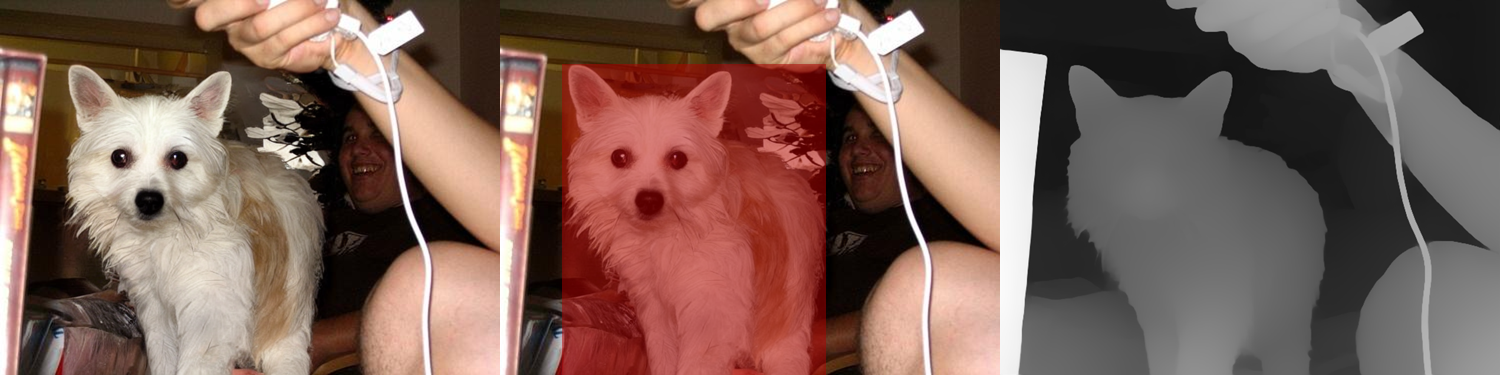

In [11]:
CombineImagesHorizontally(new_image, GetMaskedImage(new_image, cat_mask), controlnet_image)

In [16]:
img = {"image": image, "mask": person_mask}

In [ ]:
new_image, controlnet_image = model(
        input_image=img,
        control_type="depth",
        prompt="women",
        ddim_steps=50,
        scale=5,
        seed=2,
        controlnet_conditioning_scale=0.8)

In [18]:
CombineImagesHorizontally(new_image, GetMaskedImage(new_image, person_mask), controlnet_image)

### Add new object

In [9]:
# load base and mask image
image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
cat_image = load_image("https://avatars.mds.yandex.net/i?id=19db7f313270e86fed5cb2a10547dcd5_l-5087196-images-thumbs&n=13")

## Florence for postion mask

In [10]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image
import requests
import copy
import torch
%matplotlib inline

In [11]:
model_id = 'microsoft/Florence-2-large'
Florence_model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()
Florence_processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [13]:
def run_example(image , task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = Florence_processor(text=prompt, images=image, return_tensors="pt").to('cuda', torch.float16)
    generated_ids = Florence_model.generate(
      input_ids=inputs["input_ids"].cuda(),
      pixel_values=inputs["pixel_values"].cuda(),
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = Florence_processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = Florence_processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

In [15]:
task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
text_input = "A small surface at the bottom"
results = run_example(image ,task_prompt, text_input=text_input)
print(results)

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[0.25600001215934753, 395.52001953125, 511.2320251464844, 511.2320251464844], [0.25600001215934753, 430.3360290527344, 511.2320251464844, 511.2320251464844]], 'labels': ['A small surface', 'A small surface']}}


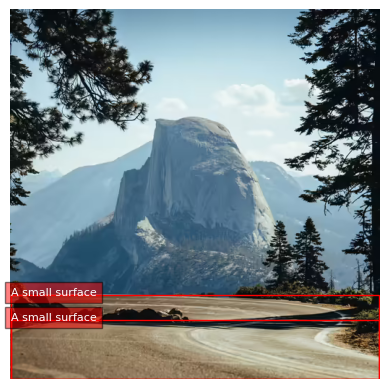

In [18]:
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

In [23]:
position_bbox = results['<CAPTION_TO_PHRASE_GROUNDING>']['bboxes'][-1]
position_bbox

[0.25600001215934753, 430.3360290527344, 511.2320251464844, 511.2320251464844]

#### Getting mask with SAM

In [24]:
from transformers import SamModel, SamProcessor

device = "cuda" if torch.cuda.is_available() else "cpu"
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

raw_image = cat_image
input_points = [[[1000, 600]]]  # 2D location of a window in the image

inputs = sam_processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
with torch.no_grad():
    sam_model.eval()
    outputs = sam_model(**inputs)
masks = sam_processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [25]:
cat_mask = Image.fromarray(masks[0][0][1].numpy().astype(np.uint8) * 255)
prompt = "white cat"

### Adding model

In [26]:
model = ObjectAdder()

vae/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--botp--stable-diffusion-v1-5-inpainting/snapshots/069f0782bc637fcbf3310d985b3d0ebffc668535/unet: Error no file named diffusion_pytorch_model.safetens

09/12 18:08:18 - mmengine - INFO - Successfully add external embeddings: P_ctxt, P_shape, P_obj.
09/12 18:08:18 - mmengine - INFO - Successfully add trainable external embeddings: P_ctxt, P_shape, P_obj


/home/jovyan/.mlspace/envs/gen_aug/lib/python3.10/site-packages/controlnet_aux/open_pose/body.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer

In [32]:
seed=3
image, controlnet_image = model(image, cat_image, cat_mask, prompt, seed, position_bbox=position_bbox)
CombineImagesHorizontally(image, controlnet_image)

248.97719009107527 166.24414463372838


  0%|          | 0/50 [00:00<?, ?it/s]